In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import os
import datetime
from tqdm import tqdm
from helpers import *

# initialize tqdm for pandas
tqdm.pandas()
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# turn off warning
import warnings
warnings.filterwarnings('ignore')

# define path
DIR = ".\\data\\raw"
PATH_DF_CHANNELS = DIR + '\\df_channels_en.tsv.gz'
PATH_DF_TIMESERIES = DIR + '\\df_timeseries_en.tsv.gz'
PATH_YT_METADATA = DIR + '\\yt_metadata_en.jsonl.gz'
PATH_NUM_COMMENTS = DIR  + '\\num_comments.tsv.gz'

In [2]:
#### to be removed ####
# clean data
CLEAN = ".\\data\\clean"
PATH_YT_TECH_EDU_METADATA = CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = CLEAN + '\\tech_review_videos.tsv.gz'

In this notebook we want to focus on the analysis of tech review channels to understand what are the main factors of success for the YouTubers in this category.

The analysis is divided into the following parts:
1. Preprocessing (filtering the tech review channels) [give link to it]
2. Characteristics of successful channels [give link to it]
3. The effect of the big tech events on the channels' growth [give link to it]

## Preprocessing

For filtering the tech review channels we are using the following method, we are first creating 2 lists with the words used in tags and titles of the videos of the most popular Tech Review YouTubers, and using these 2 lists to classify all the videos (in "Education" and "Science and Technology" categories only) to tech review videos. Then, we are classifying the channels into tech review channels depending on what fraction of all of their videos are about tech review.

In [6]:
# filter metadata only considering the videos in "Education" and "Science & Technology"
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json = df_json[['channel_id','display_id','duration','tags','title','categories']]
    df_json = df_json[(df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')]
    
    dfs.append(df_json)
df_tech = pd.concat(dfs)
df_tech.drop('categories',axis=1,inplace=True)

# some videos don't define and tag, so we set them to an empty string
df_tech['tags'].fillna('',inplace=True)


# select the videos of the most popular tech review channels
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()
df_tech_pop = df_tech[df_tech.channel_id.isin(popular_tech_channels_id)][['tags','title']]


# Find the most commonly used words both in tags and titles of the above videos
print('Cleaning title')
df_tech_pop['clean_title'] = df_tech_pop.title.progress_apply(clean_text)
print('Cleaning tags')
df_tech_pop['clean_tags'] = df_tech_pop.tags.progress_apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in df_tech_pop.clean_tags.values:
    all_tags += tags
for titles in df_tech_pop.clean_title.values:
    all_titles += titles


# clean title and tags of all the videos
df_tech_review = df_tech.copy()
print('Cleaning all titles')
df_tech_review['clean_title'] = df_tech_review.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review['clean_tags'] = df_tech_review.tags.progress_apply(clean_text)

Loading data: 730it [30:12,  2.48s/it]                               


Cleaning title


100%|██████████| 10234/10234 [00:17<00:00, 596.64it/s]


Cleaning tags


100%|██████████| 10234/10234 [00:49<00:00, 205.00it/s]


Cleaning all titles


100%|██████████| 6198568/6198568 [2:25:31<00:00, 709.94it/s]  


Cleaning all tags


100%|██████████| 6198568/6198568 [8:35:16<00:00, 200.49it/s]    


In [7]:
df_tech_review.to_csv('yt_tech_review.tsv.gz', sep="\t", compression="infer")

# # clean data
# CLEAN = "\data\\clean"
# PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
# PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
# PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
# PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

# # import ast
# # df_tech = pd.read_csv(PATH_YT_TECH_EDU_METADATA, sep="\t", compression="infer")[['channel_id','display_id','duration','tags','title']]
# # df_tech_review = pd.read_csv('yt_tech_review.tsv.gz', sep="\t", compression="infer")[['channel_id','display_id','duration','tags','title','clean_title','clean_tags']]
# # df_tech_review['clean_title'] = df_tech_review['clean_title'].apply(ast.literal_eval)
# # df_tech_review['clean_tags'] = df_tech_review['clean_tags'].apply(ast.literal_eval)

To classify the videos into tech review, we are using the following method:


First, we get the 100 most commonly used words in the titles of the videos of the most popular tech review youtubers on youtube (call it TITLES_COMMON). Then, for each video calculate what percentage of the words used in their titles occurs in TITLES_COMMON, and we repeat this proces for tags as well. Finally, if the duration of the video is less than 20 minutes, and at least 50% of the words used either in its title or tags are the ones used in TITLES_COMMON, or TAGS_COMMON, then we set this video as "tech review".

As we are selecting only the 100 most commonly used words, it may not be a perfect classification algorithm, but for the sake of this milestone, we decided to move on with the analysis with this method. We also have implemented 2 other methods (in the helpers.py[give a link to it] script) that are about TF-IDF, and Bayesian classifier. We will briefly discuss the methods here, and implement and explore them in the next milestone.

1st method:
We chose the top well-known tech YouTubers and took all titles of their videos and split titles into lists of tokens (call it CORPUS). For every token we compute its TF-IDF (#occurences / #size of all titles) * log(# titles / # titles in which token appears). Having a dictionary of TF-IDF score for each token, we compute the score of each title (of all videos) by summing up the coefficients of its tokens if present in the CORPUS or 0 if not. Finally, we set the video as “tech review”, depending on its score.

2nd method:
    We first need to form a "dict_good" python dict containing, as keys, all words from the tech review videos' titles (smoothed; i.e. we add to it all words that aren't initially in it but are among words in all titles when considering all videos) and, containing as values, the frequency of the word (probability; i.e. $ \frac{\# of occurences of the word}{(\# of occurences of all words + smoothing factor*N))} $; for words that weren't initially present, we assign to them: $ \frac{smoothing factor}{(\# of occurences of all words + smoothing factor*N)} $. Smoothing factor is chosen to be 1. N is the number of words that are added (initially not among the words from the titles of tech review videos). We also need to feed in a second argument: "dict_bad": same idea as "dict_good", but contains all other words that aren't in the titles of tech review videos (also smoothed). The 3rd argument is the title: list of the words of the title of a video to which we want to get its score. The score is the conditional proba: P(good | title). Then we compare the title's score to 0.5, if it's larger then it's likely "good" else it's considered "bad".

**The most occured words in tags**

iphone - review - unboxing - best - tech - galaxy - android - gaming - samsung - apple - pro - smartphone - phone - new - gadget - video - camera - plus - note - unbox - therapy - game - technology - headphone - oneplus - pc - laptop - google - ipad - pixel - cool - computer - beat - unboxtherapy - test - one - wireless - macbook - lg - top - tip - xbox - huawei - case - nexus - sony - setup - hd - battery - youtube - monitor - linus - tv - invention - playstation - asus - bluetooth - speaker - chap - nvidia - uravgconsumer - giveaway - consumer - max - ce - first - htc - mate - tour - xl - mkbhd - intel - gtx - air - apps - overview - smart - watch - card - edge - io - audio - hand - edition - core - keyboard - look - system - budget - build - display - razer - mobile - tablet - average - high - cheap - industry - amazon - nintendo

**The most occured words in titles**

tech - unboxing - tip - linus - first - review - look - gaming - iphone - pc - galaxy - pro - best - new - samsung - hd - chap - show - smartphone - ce - phone - asus - wan - gtx - video - case - overview - android - card - laptop - edition - test - camera - top - apple - one - giveaway - google - core - ultimate - intel - wireless - ijustine - nvidia - motherboard - headphone - monitor - note - amd - drive - corsair - setup - oneplus - keyboard - cpu - lg - geforce - plus - tutorial - performance - hand - impression - part - msi - gb - cooler - mouse - ipad - world - ssd - power - game - huawei - tv - guide - buy - day - macbook - razer - ever - pixel - computer - series - sony - youtube - usb - update - mini - speaker - headset - gadget - window - comparison - tour - beat - nexus - full - gigabyte - life - watch

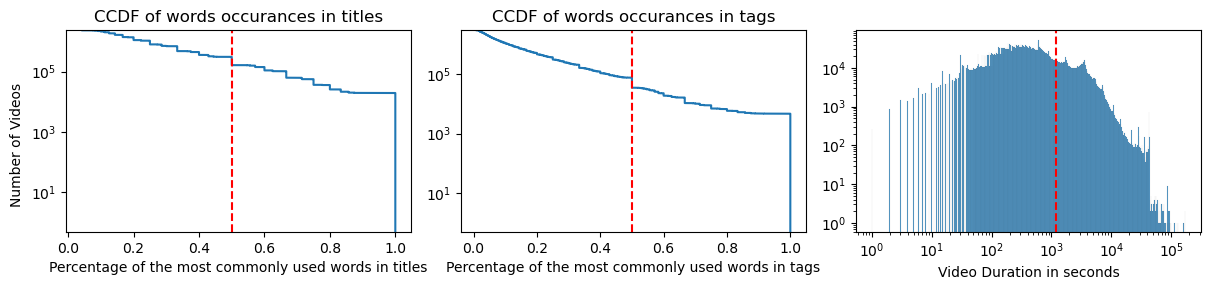

In [8]:
# get 100 most commonly used words in tags and titles of the most popular youtubers
tags_common = get_common_words(all_tags).rename({'word':'tags_unique','occurance':'tags_occurance'},axis=1)
titles_common = get_common_words(all_titles).rename({'word':'titles_unique','occurance':'titles_occurance'},axis=1)

# display the most occured words in tags and titles
markdown_tags = " - ".join(tags_common['tags_unique'].to_list())
markdown_titles = " - ".join(titles_common['titles_unique'].to_list())
display(Markdown('**The most occured words in tags**\n\n' + markdown_tags))
display(Markdown('**The most occured words in titles**\n\n' + markdown_titles))

# count the number of occurances of the above words in the tags/title of each video
df_tech_review['tags_occurances_perc'] = df_tech_review['clean_tags'].apply(lambda tags: 0 if len(tags) == 0 else (np.intersect1d(tags, tags_common['tags_unique'].unique()).shape[0] / len(tags)))
df_tech_review['title_occurances_perc'] = df_tech_review['clean_title'].apply(lambda title: 0 if len(title)==0 else (np.intersect1d(title, titles_common['titles_unique'].unique()).shape[0] / len(title)))

# plot the words distribution to highlight how we are filtering the tech review videos
fig, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
sns.ecdfplot(x = df_tech_review[df_tech_review.title_occurances_perc > 0].title_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[0])
sns.ecdfplot(x = df_tech_review[df_tech_review.tags_occurances_perc > 0].tags_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[1])
sns.histplot(x = df_tech_review.duration, stat='count', log_scale=(True, False), ax=axes2[2])
axes2[0].axvline(x=0.5, color='red', linestyle='--')
axes2[1].axvline(x=0.5, color='red', linestyle='--')
axes2[2].axvline(x=1200, color='red', linestyle='--')
axes2[0].set(title='CCDF of words occurances in titles',xlabel='Percentage of the most commonly used words in titles', ylabel=None, yscale='log')
axes2[1].set(title='CCDF of words occurances in tags', xlabel='Percentage of the most commonly used words in tags', ylabel=None, yscale='log')
axes2[2].set(xlabel='Video Duration in seconds', ylabel=None, yscale='log')
fig.text(-0.005, 0.5, 'Number of Videos', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

We filter the videos that have more than 50% of the words of their title or tags are the ones found in the most commongly used words list. Then, we filter the channels that are in Education or Science & Technology category and have more than 5% of their videos in tech review. Note that the category of the channels is assigned by the socialblade platform depending on the last 10 videos published at the time of crawl ([crawl time]) - souce([link to socialblade page])

In [9]:
# tech review videos only
df_tech_review_videos = df_tech_review[(df_tech_review.duration < 1200) & ((df_tech_review.tags_occurances_perc > 0.5) | (df_tech_review.title_occurances_perc > 0.5))]

# count the number of tech review videos per channel
count_tech_videos = df_tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

# tech review videos only
df_tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.05) & (df_tech_channels.category_cc.isin(['Education','Science & Technology']))].drop(['category_cc','tech_videos_perc'],axis=1).reset_index(drop=True)
display(df_tech_review_channels.sample(5))

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos
406,2014-12-29,UCWVyEdLMP9b6P0FOSkripLQ,TecworkZ,120198,301,131463.0,4.3110,178.0
1212,2010-01-25,UCQT1rbzlJPiwFEBNeDbJDvQ,Andy Rox,11000,77,849534.0,15.3200,7.0
269,2014-09-25,UC_nPskT9hNIUUYE7_pZK5pw,BEST REVIEWS,213000,781,78859.0,3.6855,87.0
1200,2015-09-17,UCBl1nL13BmieYFD9f1ZBS8Q,Arindam Sen,12366,38,834445.0,12.1815,2.0
418,2006-10-17,UCxn2JKjtfOy5qr1pnen79Fw,TigerDirect,114000,4338,136294.0,5.5140,342.0


Now from the youtube videos metadata, we want to filter the tech review channels only, keeping all of their videos from original metadata (both tech and non-tech).

In [10]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[df_json.channel_id.isin(df_tech_review_channels.channel_id.unique())]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
df_tech_review_mt = pd.concat(dfs)

# flag tech videos
df_tech_review_mt.loc[df_tech_review_mt.display_id.isin(df_tech_review_videos.display_id.unique()),'tech_review'] = True
df_tech_review_mt.tech_review.fillna(False, inplace=True)

# add number of comments
num_comments = pd.read_csv(PATH_NUM_COMMENTS, compression="infer", sep="\t")
df_tech_review_mt = pd.merge(df_tech_review_mt, num_comments, on='display_id', how='left')

# clean title and tags
print('Cleaning all titles')
df_tech_review_mt['clean_title'] = df_tech_review_mt.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review_mt['clean_tags'] = df_tech_review_mt.tags.progress_apply(clean_text)

Loading data: 730it [32:24,  2.66s/it]                               


Cleaning all titles


100%|██████████| 740018/740018 [16:35<00:00, 743.45it/s] 


Cleaning all tags


100%|██████████| 740018/740018 [1:09:32<00:00, 177.35it/s] 


With that we will be done with preprocessing with 2 datasets in our hand to be used throughout the analysis:
- df_tech_review_channels: Channel Data for tech review channels only
- df_tech_review_mt: Video Meatadata of tech review channels only

In [4]:
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")

# Characteristics of successful channels

### Video duration

### Upload Frequency

In [5]:
#read the file tech_review_channels.tsv.gz
Tch_chan = pd.read_pickle("tech_review_channels (1).p",compression='gzip')
Tech_videos = pd.read_csv('yt_tech_channels_metadata.tsv.gz',compression='infer',sep='\t')
TS = pd.read_table("df_timeseries_en.tsv")

In [6]:
#Write a function that gives the last date a video was uploaded to a channel
def last_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].max()

In [7]:
#Now the first date a video was uploaded to a channel
def first_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].min()

In [8]:
#It returns the number of months between two dates
def months_between_dates(date1,date2):
    return (date2.year-date1.year)*12 + (date2.month-date1.month)

In [9]:
#find the number of videos displayed on a channel
def num_videos(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['display_id'].count()

In [10]:
#Find the last upload date for each channel
Tch_chan['last_upload_date'] = Tch_chan['channel_id'].apply(last_upload_date)

In [11]:
#Add column last upload date to Tch_chan
Tch_chan['first_upload_date'] = Tch_chan['channel_id'].apply(first_upload_date)

In [12]:
#Add column months between first and last upload date
Tch_chan['months_between_dates'] = Tch_chan.apply(lambda x: months_between_dates(pd.to_datetime(x['first_upload_date']),pd.to_datetime(x['last_upload_date'])),axis=1)

In [13]:
#gIVE THE monthly frequency of uploads as a new column
Tch_chan['monthly_frequency'] = Tch_chan.apply(lambda x:  x['count_tech_videos']/max(1,x['months_between_dates']),axis=1)

In [14]:
#Took the columns that we will use to be faster
Tch_chan_freq = Tch_chan[['channel_id','subscribers_cc' ,'subscriber_rank_sb' ,'monthly_frequency']]

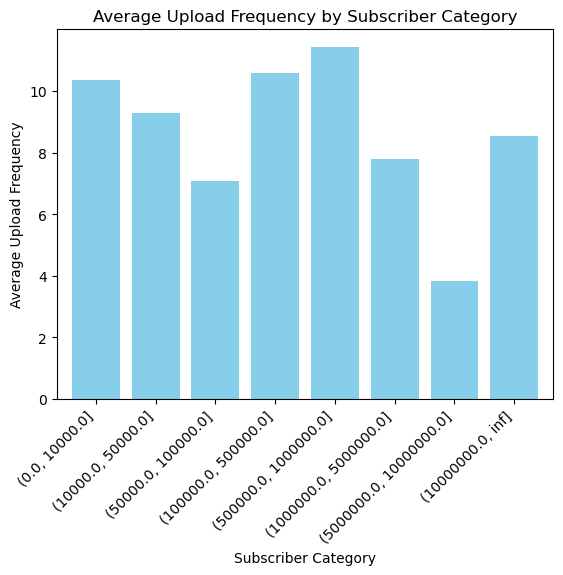

In [15]:
bin_edges = [0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, float('inf')]

# Create a new column to categorize subscribers into bins
Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)

# Group by the 'Subscriber Category' and calculate the average upload frequency
average_uploads_by_subscribers = Tch_chan_freq.groupby('Subscriber Category')['monthly_frequency'].mean()

# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='skyblue')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [16]:
#Divide youtubers into percentiles based on their subscriber rank
Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)

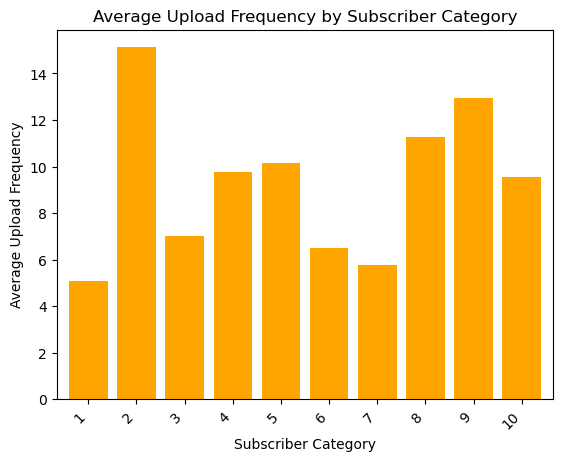

In [17]:
# Group by the 'Rank Category' and calculate the average upload frequency, the cateogry 10 is the top 10% of §ubscribers
average_uploads_by_subscribers = Tch_chan_freq.groupby('Rank Category')['monthly_frequency'].mean()
# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='orange')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Here in those two plots , I divided the tech youtubers within bings, using two metrics (numerical tresholds and percentiles), and measured the average upload frequency depending where they are, we can observe that youtubers that upload the less are small youtubers (0-10th percentile), as they are only doing it for hobby and probably have something else besides youtube, this augments clearly when they are in the 2nd bin, because they are putting a lot of efforts to be known and followed, so they have to push a lot of videos to be seen the most possible. Afterwards this upload frequency is surrounding 7 videos per week , that is here about 2 videos per week , and that's what common youtubers do in general, this frequency increases again for top tier youtubers, and this is probably because it's their main job (this is told by personal knowledge). The trend is the same as in the first plot , and we want to focus more on detail to see if there is a correlation or not between the frequency and the number of subscribers

In [18]:
mylist =['Marques Brownlee','UrAvgConsumer','Unbox Therapy','Mrwhosetheboss']
list_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ 'channel_id'].unique()
names_and_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ ['name_cc' ,'channel_id']].drop_duplicates()
names_and_ids  

,name_cc,channel_id
0,Unbox Therapy,UCsTcErHg8oDvUnTzoqsYeNw
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ
12,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA
19,UrAvgConsumer,UC9fSZHEh6XsRpX-xJc6lT3A


In [19]:
Tech_4_VID = Tech_videos[Tech_videos['channel_id'].isin(list_ids)]

In [20]:
Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])
# Sort the DataFrame by 'Release_Date'
Tech_4_VID = Tech_4_VID.sort_values('Release_Date')

In [21]:
TS_4 = TS[TS['channel'].isin(list_ids)]
Tech_4_VID_flt =Tech_4_VID[(TS_4['datetime'].max() >=Tech_4_VID['Release_Date']) & (Tech_4_VID['Release_Date']>= TS_4['datetime'].min())]

#Divided the table into one for each channel
UnboxVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCsTcErHg8oDvUnTzoqsYeNw']
MKBHDVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCBJycsmduvYEL83R_U4JriQ']
UrAvgConsumerVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UC9fSZHEh6XsRpX-xJc6lT3A']
MrwhosethebossVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCMiJRAwDNSNzuYeN2uWa0pA'] 

MKBHDVID['Youtuber'] = 'MKBHD'
UnboxVID['Youtuber'] = 'Unbox Therapy'
UrAvgConsumerVID['Youtuber'] = 'UrAverageConsumer'
MrwhosethebossVID['Youtuber'] = 'MrWhoseTheBoss'


#Put the days in order 
MKBHDVID = MKBHDVID.sort_values('Release_Date')
UnboxVID = UnboxVID.sort_values('Release_Date')
UrAvgConsumerVID = UrAvgConsumerVID.sort_values('Release_Date')
MrwhosethebossVID = MrwhosethebossVID.sort_values('Release_Date')

MKBHDVID['Year'] = MKBHDVID['Release_Date'].dt.year
MKBHDVID['Month'] = MKBHDVID['Release_Date'].dt.month
UnboxVID['Year'] = UnboxVID['Release_Date'].dt.year
UnboxVID['Month'] = UnboxVID['Release_Date'].dt.month
UrAvgConsumerVID['Year'] = UrAvgConsumerVID['Release_Date'].dt.year
UrAvgConsumerVID['Month'] = UrAvgConsumerVID['Release_Date'].dt.month
MrwhosethebossVID['Year'] = MrwhosethebossVID['Release_Date'].dt.year
MrwhosethebossVID['Month'] = MrwhosethebossVID['Release_Date'].dt.month

#Difference between release days MKBHD
MKBHDVID['diff'] = MKBHDVID['Release_Date'].diff().dt.days
UnboxVID['diff'] = UnboxVID['Release_Date'].diff().dt.days
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['Release_Date'].diff().dt.days
MrwhosethebossVID['diff'] = MrwhosethebossVID['Release_Date'].diff().dt.days

#set nan to 1
MKBHDVID['diff'] = MKBHDVID['diff'].fillna(1)
UnboxVID['diff'] = UnboxVID['diff'].fillna(1)
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['diff'].fillna(1)
MrwhosethebossVID['diff'] = MrwhosethebossVID['diff'].fillna(1)

#set 0 to 1/2
MKBHDVID['diff'] = MKBHDVID['diff'].replace(0,0.5)
UnboxVID['diff'] = UnboxVID['diff'].replace(0,0.5)
UrAvgConsumerVID['diff'] = UrAvgConsumerVID['diff'].replace(0,0.5)
MrwhosethebossVID['diff'] = MrwhosethebossVID['diff'].replace(0,0.5)

#Calculate frequency = 1/diff
MKBHDVID['Frequency'] = 1/MKBHDVID['diff']
UnboxVID['Frequency'] = 1/UnboxVID['diff']
UrAvgConsumerVID['Frequency'] = 1/UrAvgConsumerVID['diff']
MrwhosethebossVID['Frequency'] = 1/MrwhosethebossVID['diff']

MKBHDVID['MonthlyFrequencyVAR'] = MKBHDVID.groupby(['Year','Month'])['Frequency'].transform('var')
UnboxVID['MonthlyFrequencyVAR'] = UnboxVID.groupby(['Year','Month'])['Frequency'].transform('var')
UrAvgConsumerVID['MonthlyFrequencyVAR'] = UrAvgConsumerVID.groupby(['Year','Month'])['Frequency'].transform('var')
MrwhosethebossVID['MonthlyFrequencyVAR'] = MrwhosethebossVID.groupby(['Year','Month'])['Frequency'].transform('var')

<Figure size 3000x1700 with 0 Axes>

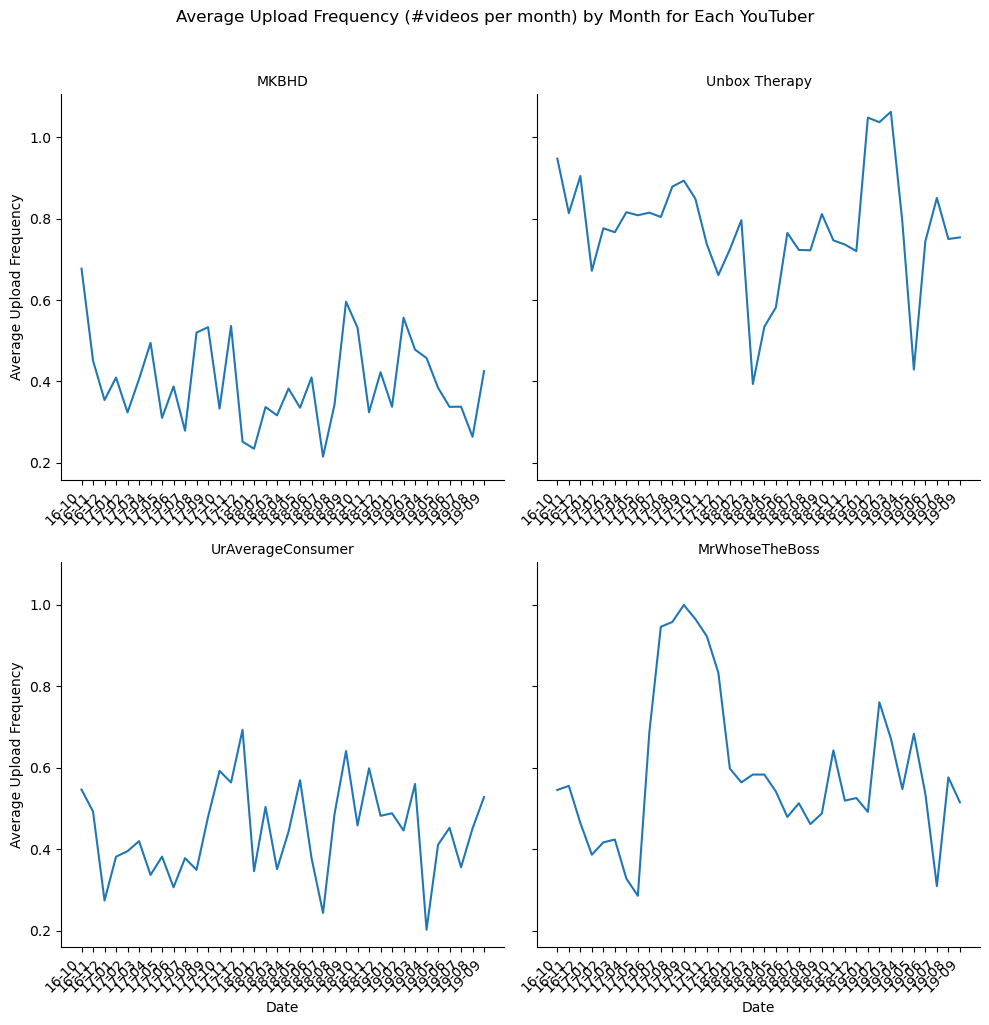

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have four DataFrames: youtuber1_df, youtuber2_df, youtuber3_df, youtuber4_df

# Add a 'Youtuber' column to each DataFrame
MKBHDVID['Youtuber'] = 'MKBHD'
UnboxVID['Youtuber'] = 'Unbox Therapy'
UrAvgConsumerVID['Youtuber'] = 'UrAverageConsumer'
MrwhosethebossVID['Youtuber'] = 'MrWhoseTheBoss'

# Combine the DataFrames into one
combined_df_freq = pd.concat([MKBHDVID, UnboxVID, UrAvgConsumerVID, MrwhosethebossVID])

combined_df_freq['FormattedDate'] = combined_df_freq['Release_Date'].dt.strftime('%y-%m')

plt.figure(figsize=(30, 17))
g = sns.FacetGrid(combined_df_freq, col='Youtuber', col_wrap=2, height=5, margin_titles=True, sharex=False)
g.map_dataframe(sns.lineplot, x='FormattedDate', y='Frequency', ci=None)
g.set_axis_labels('Date', 'Average Upload Frequency')
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45, ha='right')

plt.suptitle('Average Upload Frequency (#videos per month) by Month for Each YouTuber', y=1.02)
plt.tight_layout()
plt.show()

The major element that we should observe here is that in reality , the monthly frequency fluctuates a lot over months , as indeed youtubers are not robots, and have months where they are more productive, and can create more contents that others, we also observe that the two positive peaks are shared among all the channels studied here (october/november 2017) and (march/april 2019), probably linked to some event.

In [23]:
#plot the count of videos per year

MKBHDmonthly = MKBHDVID.copy()
Unboxmonthly = UnboxVID.copy()
UrAvgConsumermonthly = UrAvgConsumerVID.copy()
Mrwhosethebossmonthly = MrwhosethebossVID.copy()



#Getting only the features we need here month , year, number of videos in this month, and the variance of the frequency of uploads 
# (that means how much are you consistent in this month)
MKBHDMonthly=  MKBHDVID.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Unboxmonthly = Unboxmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
UrAvgConsumermonthly = UrAvgConsumermonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Mrwhosethebossmonthly = Mrwhosethebossmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()

MKBHDMonthly['Youtuber']='MKBHD'
Unboxmonthly['Youtuber']='Unbox Therapy'
UrAvgConsumermonthly['Youtuber']='UrAverageConsumer'
Mrwhosethebossmonthly['Youtuber']='MrWhoseTheBoss'




TS_MKBHD = TS_4[TS_4['channel']=='UCBJycsmduvYEL83R_U4JriQ'] 
TS_Unbox = TS_4[TS_4['channel']=='UCsTcErHg8oDvUnTzoqsYeNw'] 
TS_UrAvgConsumer = TS_4[TS_4['channel']=='UC9fSZHEh6XsRpX-xJc6lT3A']
TS_Mrwhosetheboss = TS_4[TS_4['channel']=='UCMiJRAwDNSNzuYeN2uWa0pA']



def setYearsandMonths(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Year'] = df['datetime'].dt.year
    df['Month'] = df['datetime'].dt.month
    return df

TS_MKBHD = setYearsandMonths(TS_MKBHD)
TS_Unbox = setYearsandMonths(TS_Unbox)
TS_UrAvgConsumer = setYearsandMonths(TS_UrAvgConsumer)
TS_Mrwhosetheboss = setYearsandMonths(TS_Mrwhosetheboss)

In [28]:
#Get the delta number of subscribers per month
#Get the delta number of subscribers per month
def get_rel_deltasubs(df):
    monthlydf = df.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()
    monthlydf['RelativeDeltaSubs'] = monthlydf['delta_subs']/monthlydf['subs']
    return monthlydf


monthlyTS_MKBHD = get_rel_deltasubs(TS_MKBHD)
monthlyTS_Unbox = get_rel_deltasubs(TS_Unbox)
monthlyTS_UrAvgConsumer = get_rel_deltasubs(TS_UrAvgConsumer)
monthlyTS_Mrwhosetheboss = get_rel_deltasubs(TS_Mrwhosetheboss)

monthlyTS_MKBHD['Youtuber']='MKBHD'
monthlyTS_Unbox['Youtuber']='Unbox Therapy'
monthlyTS_UrAvgConsumer['Youtuber']='UrAverageConsumer'
monthlyTS_Mrwhosetheboss['Youtuber']='MrWhoseTheBoss'

In [29]:
mergedMKBHD = pd.merge(MKBHDMonthly, monthlyTS_MKBHD, on=['Year', 'Month','Youtuber'])
mergedUnbox = pd.merge(Unboxmonthly, monthlyTS_Unbox, on=['Year', 'Month','Youtuber'])
mergedUrAvgConsumer = pd.merge(UrAvgConsumermonthly, monthlyTS_UrAvgConsumer, on=['Year', 'Month','Youtuber'])
mergedMrwhosetheboss = pd.merge(Mrwhosethebossmonthly, monthlyTS_Mrwhosetheboss, on=['Year', 'Month','Youtuber'])

#The monthly regularity is a metric that I use to measure how consistent a youtuber is in his uploads , without forgetting the video count
mergedMKBHD['Monthly_Regularity']=mergedMKBHD['display_id']/mergedMKBHD['MonthlyFrequencyVAR']
mergedUnbox['Monthly_Regularity']=mergedUnbox['display_id']/mergedUnbox['MonthlyFrequencyVAR']
mergedUrAvgConsumer['Monthly_Regularity']=mergedUrAvgConsumer['display_id']/mergedUrAvgConsumer['MonthlyFrequencyVAR']
mergedMrwhosetheboss['Monthly_Regularity']=mergedMrwhosetheboss['display_id']/mergedMrwhosetheboss['MonthlyFrequencyVAR']


mergedMKBHD.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUnbox.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUrAvgConsumer.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedMrwhosetheboss.rename(columns={'display_id': 'Video_Count'}, inplace=True)

In [30]:
combined_df = pd.concat([mergedMKBHD, mergedUnbox, mergedUrAvgConsumer, mergedMrwhosetheboss])

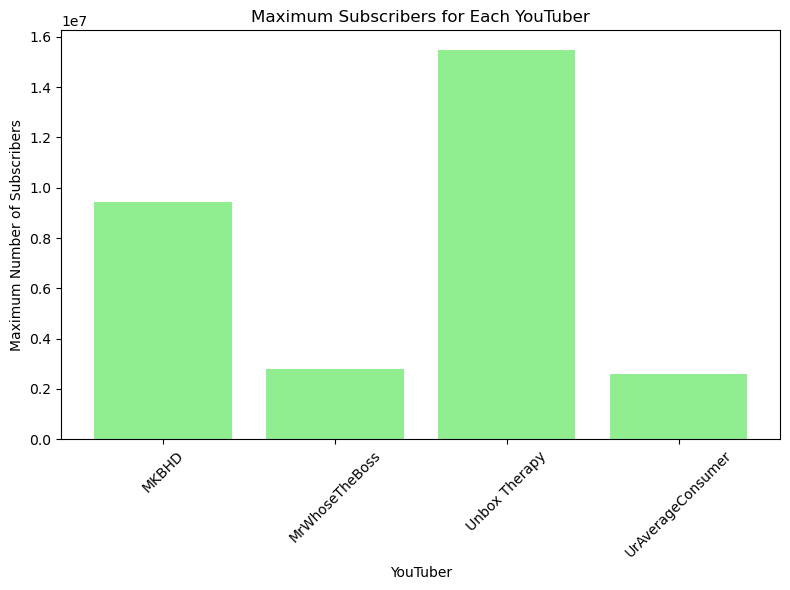

In [31]:
max_subscribers = combined_df.groupby('Youtuber')['subs'].max().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(max_subscribers['Youtuber'], max_subscribers['subs'], color='lightgreen')
plt.xlabel('YouTuber')
plt.ylabel('Maximum Number of Subscribers')
plt.title('Maximum Subscribers for Each YouTuber')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability if needed
plt.tight_layout()

plt.show()

In this plot , we can observe that Unbox Therapy is the one with the most subscribers , followed by MKBHD, then UrAverageConsumer and MrWhoseTheBoss. Let's see if this ranking influences our study, and this agrees with the naive study when studying among wide cateogries.

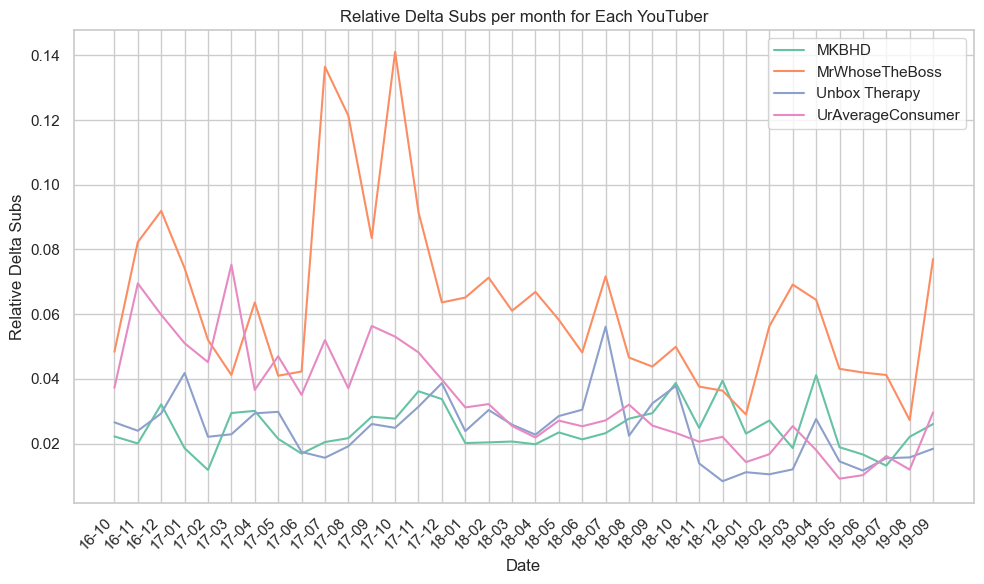

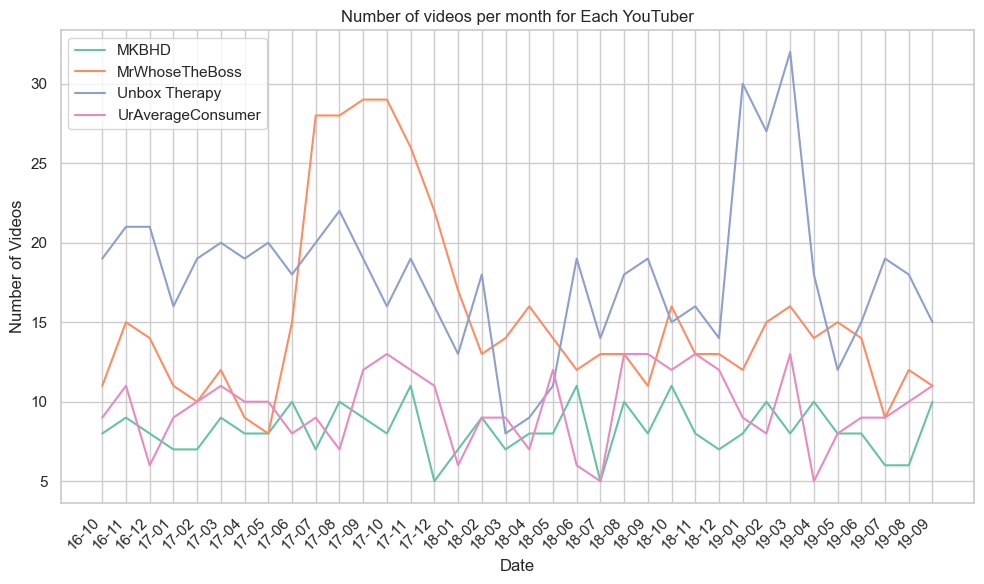

In [32]:

# Convert 'Year' and 'Month' to datetime format and create a new 'Date' column
combined_df['Date'] = pd.to_datetime(combined_df[['Year', 'Month']].assign(DAY=1))
# Format the 'Date' column as 'YY-MM'
combined_df['Date'] = combined_df['Date'].dt.strftime('%y-%m')
# Sort the DataFrame by the 'Date' column
combined_df = combined_df.sort_values(by='Date')
sns.set(style="whitegrid")
# Choose a color palette
palette = sns.color_palette("Set2")
# Assuming the necessary dataframes are defined

# Create a line plot for Relative Delta Subs
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['RelativeDeltaSubs'], label=youtuber, color=palette[i])

plt.title('Relative Delta Subs per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Relative Delta Subs')
plt.legend()
plt.tight_layout()
plt.show()

# Create a line plot for Number of videos per month
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['Video_Count'], label=youtuber, color=palette[i])

plt.title('Number of videos per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Videos')
plt.legend()
plt.tight_layout()
plt.show()

Here we can clearly observe a common trend that are shared by all youtubers, and that is pretty straightforward since pushing more videos per month will probably make you augment subscribers , since videos will appear more on the homepages of people.
I decided here to use relative delta subs instead of real deltasubs because we want to calculate a growth rate in terms of deltasubs, you are more likely to have more subscribers if you already have a lot of subscribers, hence we should divide by the total number of subs.

In [33]:
#calculate the correlation between delta videos and delta subs for MKBHD
print("MKBHD:")
MKBHDcorr = mergedMKBHD['Video_Count'].corr(mergedMKBHD['RelativeDeltaSubs'])
print(MKBHDcorr, '\n')


#calculate the correlation between delta videos and delta subs for Unbox Therapy
print("Unbox Therapy:")
Unboxcorr = mergedUnbox['Video_Count'].corr(mergedUnbox['RelativeDeltaSubs'])
print(Unboxcorr , '\n')

print("UrAverageConsumer:")
UrAvgcorr = mergedUrAvgConsumer['Video_Count'].corr(mergedUrAvgConsumer['RelativeDeltaSubs'])
print(UrAvgcorr , '\n')

print("MrWhoseTheBoss:")
Mrwhosethebosscorr = mergedMrwhosetheboss['Video_Count'].corr(mergedMrwhosetheboss['RelativeDeltaSubs'])
print(Mrwhosethebosscorr, '\n')


print('On average:')
print(combined_df['Video_Count'].corr(combined_df['RelativeDeltaSubs']))


MKBHD:
0.2936335807052104 

Unbox Therapy:
-0.2990995509724465 

UrAverageConsumer:
0.1774939368878631 

MrWhoseTheBoss:
0.7628583575997314 

On average:
0.34232653526978646


We can observe here that the number of videos submitted is really important for MrWhoseTheboss as 0.76 is a very significant correlation,that confirms the visual impression when seing the two plots. MKBHD has a not that significant correlation , but it's still positive and relevant, and justifies the same trend between number of videos and  the delta subs evolution. Overall, this positive correlation confirms what we will naturally think, the more videos you push the more subscribers you might got

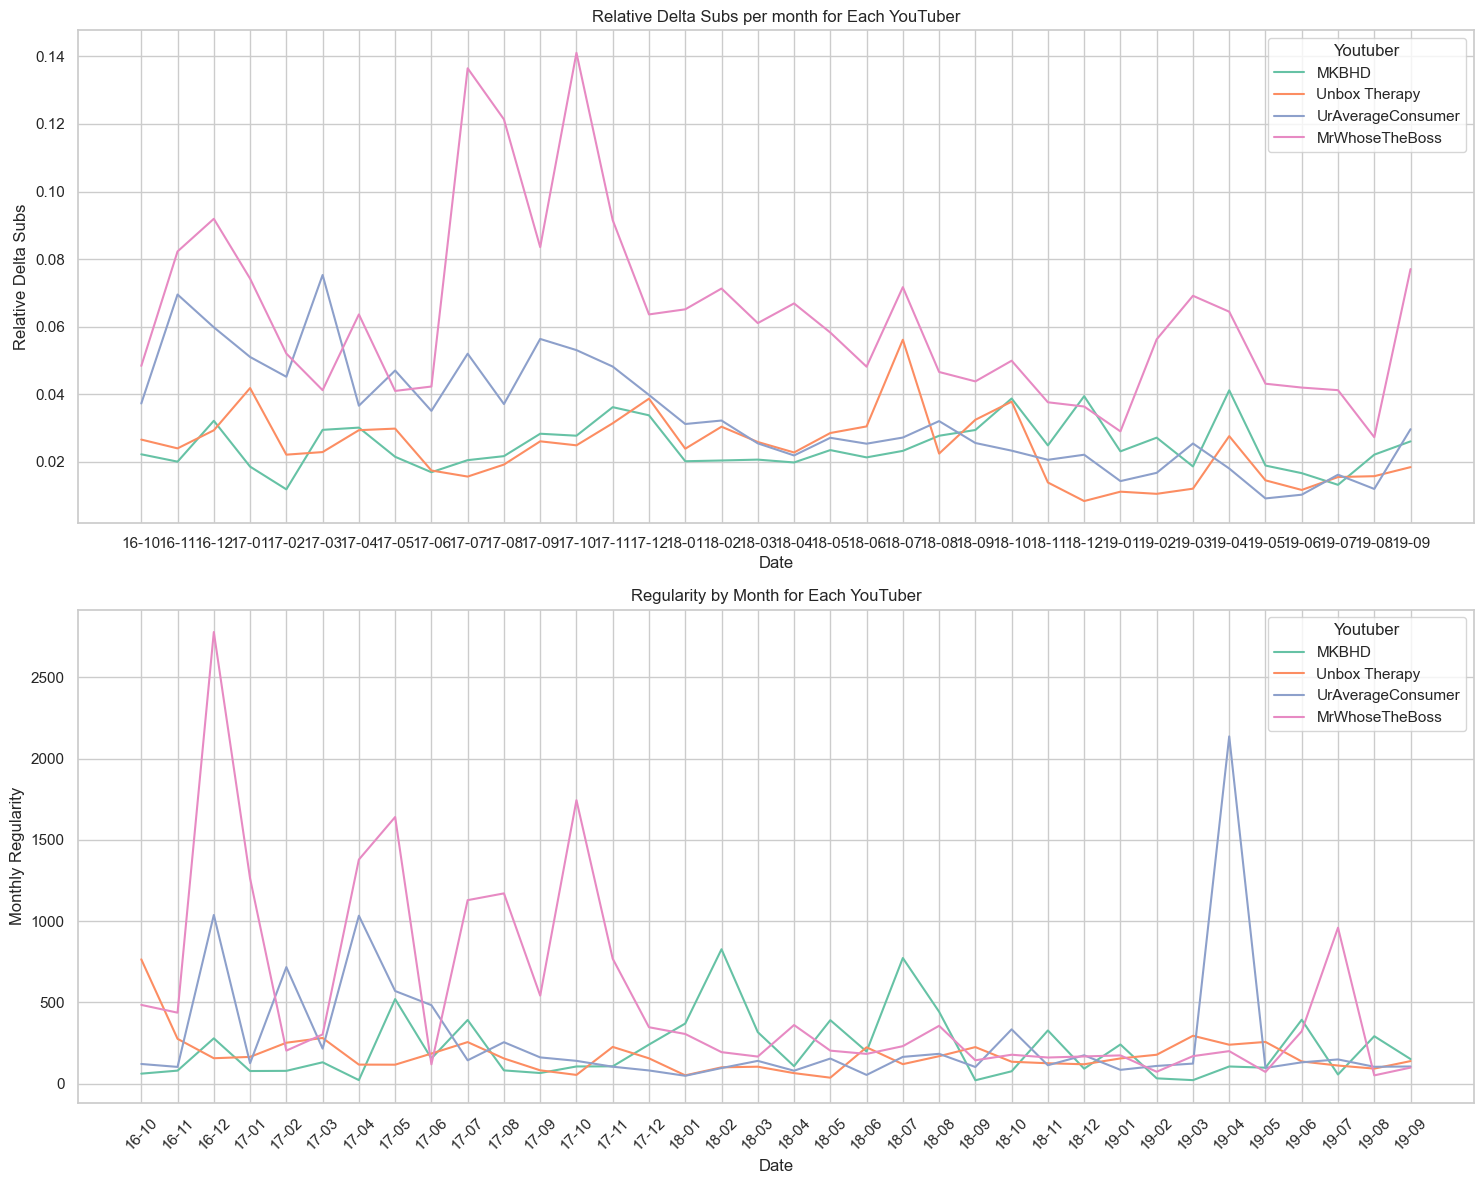

In [35]:

# Define a consistent palette for Youtubers
palette = sns.color_palette("Set2")

sns.set(style="whitegrid")

# Create subplots with a consistent palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# ---- First Subplot: Relative Delta Subs per month ----
sns.lineplot(x='Date', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df, ci=None, ax=ax1, palette=palette)
plt.xticks(rotation=45)
ax1.set_title('Relative Delta Subs per month for Each YouTuber')
ax1.set_ylabel('Relative Delta Subs')
ax1.legend(title='Youtuber')

# ---- Second Subplot: Average Upload Frequency per month ----
sns.lineplot(x='Date', y='Monthly_Regularity', hue='Youtuber', data=combined_df, ci=None, ax=ax2, palette=palette)
ax2.set_title('Regularity by Month for Each YouTuber')
plt.xticks(rotation=45)
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Regularity')
ax2.legend(title='Youtuber')

# Adjust layout
plt.tight_layout()
plt.show()

We can clearly observe the same trend, this is to be explored more generally     

In [36]:

#print correlations for each youtuber between regularity and relative delta subs
print('MKBHD: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMKBHD['Monthly_Regularity'].corr(mergedMKBHD['RelativeDeltaSubs']), '\n')
print('Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUnbox['Monthly_Regularity'].corr(mergedUnbox['RelativeDeltaSubs']), '\n')
print('UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUrAvgConsumer['Monthly_Regularity'].corr(mergedUrAvgConsumer['RelativeDeltaSubs']), '\n')
print('MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMrwhosetheboss['Monthly_Regularity'].corr(mergedMrwhosetheboss['RelativeDeltaSubs']), '\n')


print('on average:')
print(combined_df['Monthly_Regularity'].corr(combined_df['RelativeDeltaSubs']))

MKBHD: Correlation between Monthly Regularity and Relative Delta Subs
-0.17412497452777903 

Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs
-0.039021994429198834 

UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs
0.05630108487815437 

MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs
0.5398005184290603 

on average:
0.4704160212324767


What we can observe here is that there is a visible common trend for MrWhoseTheBoss ,and the Average Consumer. And specially for MrWhoseTheBoss.
And when we see the countplot above, this confirms that smaller youtubers need to upload a lot to improve and to evolve in terms of number of subscribers, The Average consumer , second to last in our set of 4 youtubers, has also a positive correlation (even if very small).
So on average, we might think that having a sustainable ryhtm and frequency of video uploads will help you to have more subscribers, and we want to explore this with a bigger set and generalize our study.

### Tech products range to review

In [12]:
# clean data
CLEAN = ".\\data\\clean"
PATH_YT_TECH_CHANNELS_METADATA = CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = CLEAN + '\\tech_review_channels.tsv.gz'
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA,compression="infer", sep="\t")
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS,compression="infer", sep="\t")

In this section, we are going to analyze if covering a wider range of tech products is more effective to gain more subscribers, or should the channels focus on a specific type of tech.

Here, we are assessing 3 tech types, such as phone, camera, and laptop, and we are classifying videos into one of these 3 (or none), depending on some keywords that are relevant to these tech types. Then for each channel, we are calculating the percentage of camera, phone, and laptop videos:

In [13]:
# define some keywords for 3 categories of tech: laptop, phone, camera
keywords = {
    'laptop':['laptop','macbook','zenbook','vivobook','chromebook','aspire','inspiron','legion','macos','ram','cpu','monitor','keyboard','mouse','linux','windows'],
    'phone':['mobile','phone','smartphone','cellphone','verizon','iphone','android','galaxy','pixel','oneplus','ios','case','nexus','redmi','reno','nokia','htc','realme'],
    'camera':['camera','dslr','mirrorless','canon','nikon','sony','fujifilm','gopro','aperture','shutter','iso','tripod','lens','portrait']
}
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# all the videos are classified into 1 of the 3 categories, but just in case...
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos either about phone, laptop, or camera: ", tech_df_prd.shape[0])

# get the percentage of videos in 3 categories per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

Number of videos in metadata:  740016
Number of videos either about phone, laptop, or camera:  380478


product_category,camera,laptop,phone
channel_id,,,
UCW6J17hZ_Vgr6cQgd_kHt5A,0.197970,0.258883,0.543147
UCark4B2q22cutojP6bzm2kQ,0.052632,0.631579,0.315789
UCsLNbGms_uWulcmbEqfZ_Pg,0.149254,0.492537,0.358209
UCnS-sZJLnwQhzfo7b8sxhTg,0.333333,0.190476,0.476190
UCQBX4JrB_BAlNjiEwo1hZ9Q,0.327945,0.087760,0.584296


Let's see in what categories more successful YouTubers tend to produce tech review videos by plotting the moving average (with window size of 50) of product type percentages over the rank of the YouTubers.

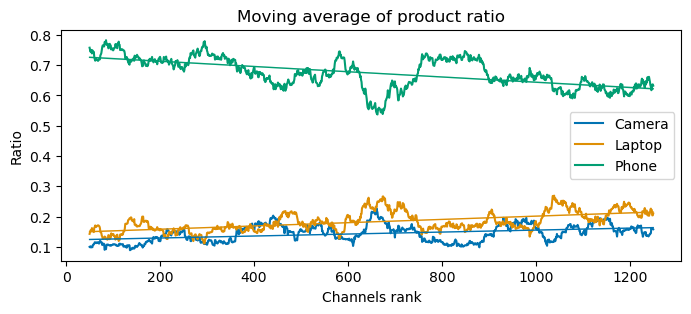

In [14]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[(tech_df_prd_perc['camera'] > 0.8) | (tech_df_prd_perc['laptop'] > 0.8) | (tech_df_prd_perc['phone'] > 0.8),'wide_range'] = False
tech_df_prd_perc['wide_range'].fillna(True, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",3)
plt.figure(figsize=(8,3))

# plot moving average
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), label='Camera',color=colors[0])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), label='Laptop',color=colors[1])
ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), label='Phone', color=colors[2])

# Add regression lines
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['camera'].rolling(50).mean(), scatter=False, ax=ax, color=colors[0], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['laptop'].rolling(50).mean(), scatter=False, ax=ax, color=colors[1], line_kws={'linewidth': 1})
sns.regplot(x=channels_rank['new_rank'], y=channels_rank['phone'].rolling(50).mean(), scatter=False, ax=ax, color=colors[2], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


As we can see, most channels tend to focus on phones, and the higher the channels' rank, the more focus it has on a single product (in our case phones), and as the rank gets lower the ratio of products tend to get closer, meaning the channels are covering wider range of product types.

Below, we analyze the effect of covering wider/narrow range of products on the number of subscriber. But before that we want to balance the dataset on some metrics, namely average duration of videos per channel, and the delay in time between publishing 2 sequential videos. Below, we compute these metrices per video, and compute their micro averages.

In [15]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range','new_rank']],on='channel_id',how='right')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
display(df_obs.sample(5))

,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,new_rank
31,UCuw8B6Uv0cMWtV5vbNpeH_A,1950000,614.757112,18.722978,0,32
173,UCyAiWg2rIQe_7Y4IfuEqluw,382000,463.380103,13.984137,0,174
697,UCUdgDNPGYCRJraG3BGxF2UA,43600,227.130853,1.213523,0,706
912,UCcdKjoU_7733lU1-nAlIP_Q,23700,124.532605,10.826834,1,926
647,UCVrSYkR10_JxMM7S64ZVSMw,54100,468.123262,19.300275,0,656


Here we plot some statistics of average delay and average duration of videos, and the number of subscribers distribution comparison before and after balancing the datasets.

Optimization terminated successfully.
         Current function value: 0.685828
         Iterations 5


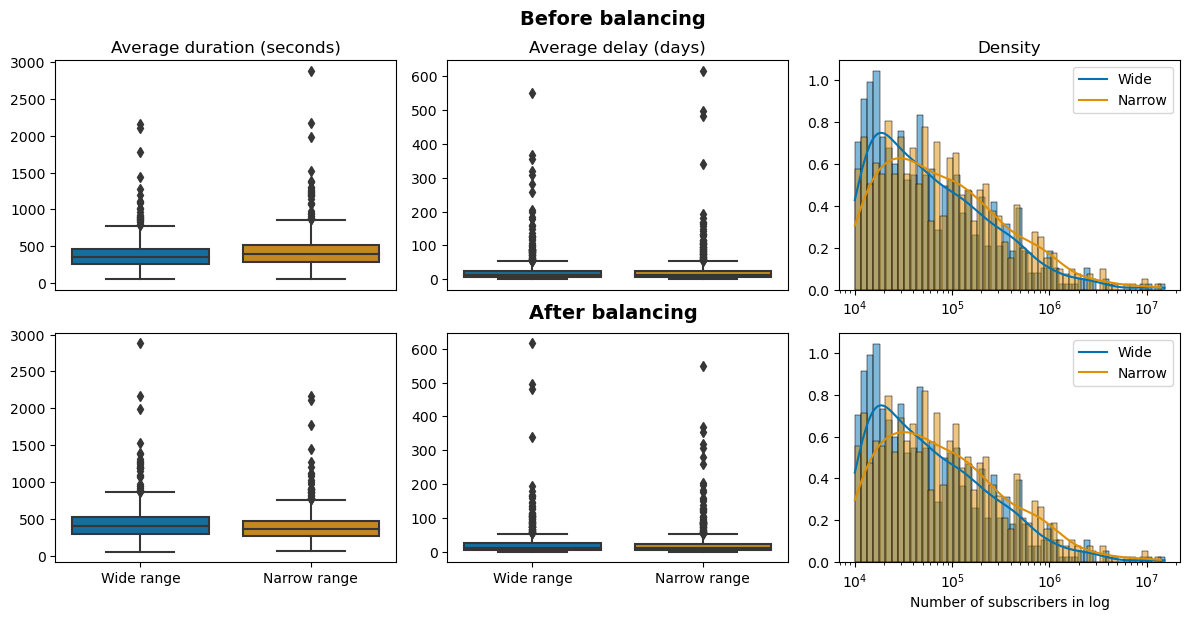

In [16]:
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,6))

# plot
sns.boxplot(y=df_obs['avg_duration'],x=df_obs['wide_range'],ax=axes[0][0],palette=colors)
sns.boxplot(y=df_obs['avg_delay'],x=df_obs['wide_range'],ax=axes[0][1],palette=colors)
sns.histplot(df_obs[df_obs['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[0][2],color=colors[0])
sns.histplot(df_obs[df_obs['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[0][2],color=colors[1])

axes[0][0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[0][2].set(title='Density',xlabel=None,ylabel=None)
axes[0][2].legend(['Wide','Narrow'])

# balance the data
match_index = balance_data(df_obs,treat_column='wide_range',continuous_features=['avg_duration','avg_delay'])
df_obs_matched = df_obs.iloc[match_index]

# plot obs
sns.boxplot(y=df_obs_matched['avg_duration'],x=df_obs_matched['wide_range'].replace({1:'Wide range', 0:'Narrow range'}),ax=axes[1][0],palette=colors)
sns.boxplot(y=df_obs_matched['avg_delay'],x=df_obs_matched['wide_range'].replace({1:'Wide range', 0:'Narrow range'}),ax=axes[1][1],palette=colors)
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][2],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][2],color=colors[1])

axes[1][0].set(xlabel=None,ylabel=None)
axes[1][1].set(xlabel=None,ylabel=None)
axes[1][2].set(xlabel='Number of subscribers in log',ylabel=None)
axes[1][2].legend(['Wide','Narrow'])

fig.text(0.515, 1.01, 'Before balancing', va='center', ha='center', fontweight='bold', fontsize=14)
fig.text(0.515, 0.52, 'After balancing', va='center', ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

The distribution of the Wide and Narrow channels shows us that the channels with narrow focus on a particular tech product is almost always domonating (especially as the number of subscribers get higher). It is also inline with the previous analysis. ...

# To do 
- write your conclustion
- what are the further steps to be done in milestone 3


# Big tech events

In [25]:
def score_per_day(df, item, release_date):
    """
    Given a product name, fetches the df for videos with titles containing the name of the product
    that were uploaded within 6 months of the product's release date and computes the total view count,
    total likes total dislikes and number of videos per day.
    :param item: product name
    :param df: dataframe of videos with titles containing the name of the product
    :return: dataframe of total view count, total likes total dislikes and number of videos per day
    """

    # filter out titles that do not contain the product name
    df = df[df["title"].str.lower().str.contains(item)]
    
    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # convert 'upload_date' to datetime
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # keep only rows that were uploaded within 3 months of the product's release date
    df = df[(df["upload_date"] >= release_date - datetime.timedelta(days=90)) & (df["upload_date"] <= release_date + datetime.timedelta(days=90))]

    # keep only 'view_count', 'upload_date', 'likes', 'dislikes', 'title'
    df = df[["view_count", "upload_date", "like_count", "dislike_count", "title"]]

    # group by 'upload_date'
    df = df.groupby("upload_date")

    # compute total view count, total like_count, total dislike_count and number of videos per day
    df = df.agg({"view_count": "sum", "like_count": "sum", "dislike_count": "sum", "title": "count"})

    return df

def plot_scores(scores_df, release_date, product_name):
    """
    Given a dataframe of view count, like count, dislike count and number of videos per day,
    plots the view count, like - dislike ratio, number of videos per day and average views per video over time.
    :param scores_df: dataframe of view count, like count, dislike count and number of videos per day
    :return: None
    """

    # plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
    axs[0][0].bar(scores_df.index, scores_df["view_count"])
    axs[0][0].set_title("Number of Views")
    axs[0][0].axvline(x=release_date, color="red", linestyle="--")

    axs[0][1].bar(scores_df.index, scores_df["like_count"])
    axs[0][1].set_title("Number of Likes")
    axs[0][1].axvline(x=release_date, color="red", linestyle="--")

    axs[1][0].bar(scores_df.index, scores_df["title"])
    axs[1][0].set_title("Number of Videos")
    axs[1][0].axvline(x=release_date, color="red", linestyle="--")

    axs[1][1].bar(scores_df.index, scores_df["view_count"] / scores_df["title"])
    axs[1][1].set_title("Average Views Per Video")
    axs[1][1].axvline(x=release_date, color="red", linestyle="--")
    

    # give a big title to the entire figure
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=20)
    plt.tight_layout()
    plt.show()

def get_sum_views(df):
    df_view = df[["view_count", "upload_date"]].copy()
    df_view["upload_date"] = pd.to_datetime(df_view["upload_date"])
    df_view = df_view.dropna(subset = ["view_count", "upload_date"])
    df_view["view_count"] = df_view["view_count"].astype("int64")

    # keep only 'view_count' and 'upload_date'
    df_view = df_view.groupby("upload_date")[['view_count']].sum()
    
    return df_view

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora, models
import pyLDAvis.gensim_models

def get_lda_topics(df, num_topics, num_words):
    # tokenize words
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["title"].apply(tokenizer.tokenize)

    # convert to lowercase
    df["tokens"] = df["tokens"].apply(lambda x: [word.lower() for word in x])
    
    # remove stop words
    stop_words = stopwords.words('english')
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # remove words that appear only once
    all_tokens = sum(df["tokens"], [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in tokens_once])

    # remove the token 'iphone'
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word != "iphone"])

    # remove one character tokens
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if len(word) > 2])
    
    # create dictionary and corpus
    dictionary = corpora.Dictionary(df["tokens"])
    corpus = [dictionary.doc2bow(text) for text in df["tokens"]]
    
    # create LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    
    # print topics
    topics = lda.show_topics(num_topics=3, num_words=10, formatted=False)
    for topic_id, words in topics:
        print(f"Topic {topic_id + 1}: {', '.join(word[0] for word in words)}")

    # visualize topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

    # assign topics to each row
    df_with_topics = df.copy()
    df_with_topics["dominant_topic"] = df_with_topics["tokens"].apply(lambda x: max(lda.get_document_topics(dictionary.doc2bow(x)), key=lambda item: item[1])[0])

    return df_with_topics


ModuleNotFoundError: No module named 'pyLDAvis'

In [6]:
item = 'iphone x'
release_date = {'iphone x': pd.to_datetime('2017-11-03')}

Loading data: 730it [49:08,  4.04s/it]                               


Number of videos about Iphone X within 3 month of its release: 2820


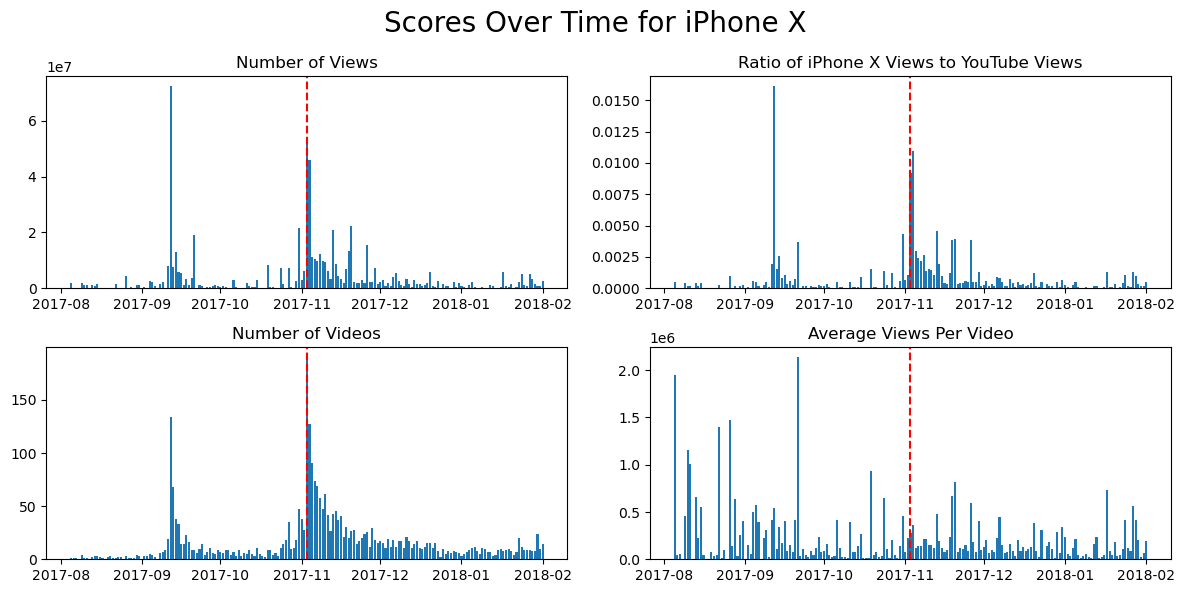

In [18]:
# 2 videos are missing title, so we ignore them
df_tech_review_mt = df_tech_review_mt[df_tech_review_mt.title.notna()]
# get only the iphone x videos
iphone_df = df_tech_review_mt[df_tech_review_mt['title'].str.lower().str.contains(item)].copy()

# from the raw dataset, we want to get the number of total views on all YouTube videos per day
yt_date_views = {}
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags", "categories"], inplace=True, axis=1)

    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[(df_json['upload_date'] >= release_date[item] - datetime.timedelta(days=90)) & ((df_json['upload_date'] <= release_date[item] + datetime.timedelta(days=90)))]

    # # filter out titles that contain iphone x in the categories "Education" and "Science & Technology"
    # df_item = df_json[((df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')) & (df_json["title"].str.lower().str.contains(item))]

    # item_views = get_sum_views(df_item)
    youtube_views = get_sum_views(df_json)

    # for each 'upload_date, get the corresponding 'view_count' in youtube_views
    for date in youtube_views.index:
        if date in yt_date_views:
            yt_date_views[date] += youtube_views.loc[date]["view_count"]
        else:
            yt_date_views[date] = youtube_views.loc[date]["view_count"]

# 2 dataframes corresponding to number of views of all videos and the ones about iphone x per day
yt_date_views_df = pd.DataFrame.from_dict(yt_date_views, orient="index", columns=["view_count"])
iphone_date_views_df = get_sum_views(iphone_df)

# merge dataframes on the 'upload_date' column and get the ratio
merged_df = pd.merge(yt_date_views_df, iphone_date_views_df, left_index=True, right_index=True)
merged_df = merged_df.rename(columns={"view_count_x": "youtube_view_count", "view_count_y": "iphone_view_count"})
merged_df["ratio"] = merged_df["iphone_view_count"] / merged_df["youtube_view_count"]

# get some metrics of iphone x videos per day
df_score = score_per_day(iphone_df, 'iphone x', release_date[item])
print('Number of videos about Iphone X within 3 month of its release:', df_score.title.sum())

# plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs[0][0].bar(df_score.index, df_score["view_count"])
axs[0][0].set_title("Number of Views")
axs[0][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[0][1].bar(merged_df.index, merged_df["ratio"])
axs[0][1].set_title("Ratio of iPhone X Views of Tech Channels to All YouTube Views")
axs[0][1].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][0].bar(df_score.index, df_score["title"])
axs[1][0].set_title("Number of Videos")
axs[1][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][1].bar(df_score.index, df_score["view_count"] / df_score["title"])
axs[1][1].set_title("Average Views Per Video")
axs[1][1].axvline(x=release_date[item], color="red", linestyle="--")


# give a big title to the entire figure
fig.suptitle("Scores Over Time for {product_name}".format(product_name='iPhone X'), fontsize=20)
plt.tight_layout()
plt.show()

As we can see from the above plots, September 2017 and November 2017 are all months with very high user interaction with videos about the iPhone. We can also clearly see that the number of views and videos released about the iPhone X reach peaks in September and November 2017. September 2017 is the month where iPhone X was announced and November 2017 is the month where the iPhone X was released.

It is also interesting to see the ratio of videos by tech youtubers to all videos. The fact that it reached 1.5% means during theses periods the tech youtubers have chance to attract viewers from other categories as well.

We can see the Youtube platform is most active around one month before the release of a product and at the time of its release. We can also further analyse is for other major tech events to come to some conclusion.

Having seen this, we would like to know what topics are the most discussed in the videos about the iPhone. during these two periods.

In [22]:
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# divide the video release date into 2 part (pre, during)
pre_release = iphone_df[(iphone_df["upload_date"] <= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=90))]
release = iphone_df[(iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date['iphone x'] + datetime.timedelta(days=30))]

# keep only top 30% most viewed videos
pre_release = pre_release.sort_values(by="view_count", ascending=False)
pre_release = pre_release.iloc[:int(len(pre_release) * 0.3)]
release = release.sort_values(by="view_count", ascending=False)
release = release.iloc[:int(len(release) * 0.3)]

In [23]:
print('Pre-release topics: ')
pre_release_topics = get_lda_topics(pre_release, 3, 10)

Pre-release topics: 
Topic 1: apple, new, face, event, cnet, hand, news, best, everything, comparison
Topic 2: plus, apple, galaxy, samsung, note, hand, leak, talk, tech, camera
Topic 3: buy, galaxy, reason, plus, note, get, one, know, thing, phone


In [24]:
print('During-release topics: ')
release_topics = get_lda_topics(release, 3, 10)

During-release topics: 
Topic 1: review, case, test, apple, camera, plus, speed, galaxy, best, samsung
Topic 2: unboxing, apple, first, camera, daily, pocketnow, comparison, feature, setup, review
Topic 3: test, speed, apple, note, galaxy, comparison, pixel, camera, tip, drop


As we can see, topics discussed in the pre-release period and during the release period are very different.
In pre-release period, the videos mostly talk about:
- Leaking information about the iPhone X
- Unboxing of clones or possible prototypes of the iPhone X
- Possible features of the iPhone X

And during the release period, the videos mostly talk about:
- Unboxing of the iPhone X
- Reviews of the iPhone X
- Comparisons between the iPhone X and other phones
- Testing different features of the iPhone X such as the camera, the screen, the battery, etc.